<a href="https://colab.research.google.com/github/zbaraskaya/-/blob/main/%D0%92%D0%9A%D0%A0_%D1%87%D0%B0%D1%81%D1%82%D1%8C_1_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Прогнозирование конечных свойств новых материалов
На входе имеются данные о начальных свойствах компонентов композиционных материалов (количество связующего, наполнителя, температурный режим отверждения и т.д.). На выходе необходимо спрогнозировать ряд конечных свойств получаемых композиционных материалов.


Загружаем все необходимые для выполнения работы библиотеки

In [ ]:
! pip install mxnet autogluon 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor

In [ ]:
# библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
#import pandas as pd
import numpy as np
import copy
#import seaborn as sns
#import matplotlib.pyplot as plt
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
print(tf.__version__)

2.9.2


Выгружаем данные для анализа

In [ ]:
x_bp = pd.read_excel('/content/X_bp.xlsx')
x_bp.head(3)
x_bp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023 entries, 0 to 1022
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Unnamed: 0                            1023 non-null   float64
 1   Соотношение матрица-наполнитель       1023 non-null   float64
 2   Плотность, кг/м3                      1023 non-null   float64
 3   модуль упругости, ГПа                 1023 non-null   float64
 4   Количество отвердителя, м.%           1023 non-null   float64
 5   Содержание эпоксидных групп,%_2       1023 non-null   float64
 6   Температура вспышки, С_2              1023 non-null   float64
 7   Поверхностная плотность, г/м2         1023 non-null   float64
 8   Модуль упругости при растяжении, ГПа  1023 non-null   float64
 9   Прочность при растяжении, МПа         1023 non-null   float64
 10  Потребление смолы, г/м2               1023 non-null   float64
dtypes: float64(11)
me

In [ ]:
x_nup = pd.read_excel('/content/X_nup.xlsx')
x_nup.head(3)
x_nup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040 entries, 0 to 1039
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          1040 non-null   float64
 1   Угол нашивки, град  1040 non-null   float64
 2   Шаг нашивки         1040 non-null   float64
 3   Плотность нашивки   1040 non-null   float64
dtypes: float64(4)
memory usage: 32.6 KB


Проводим оценку исходных данных:
длина датасетов не одинаковая

In [ ]:
print('длина 1-го датасета:', len(x_bp), 'длина 2-го датасета:', len(x_nup))

длина 1-го датасета: 1023 длина 2-го датасета: 1040


In [ ]:
x_bp.tail(3)

,Unnamed: 0,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2"
1020,1020.0,3.280604,1972.372865,416.836524,110.533477,23.957502,248.423047,740.142791,74.734344,2662.906040,236.606764
1021,1021.0,3.705351,2066.799773,741.475517,141.397963,19.246945,275.779840,641.468152,74.042708,2071.715856,197.126067
1022,1022.0,3.808020,1890.413468,417.316232,129.183416,27.474763,300.952708,758.747882,74.309704,2856.328932,194.754342


In [ ]:
x_nup.tail(3)

,Unnamed: 0,"Угол нашивки, град",Шаг нашивки,Плотность нашивки
1037,1037.0,90.0,9.800926,72.858286
1038,1038.0,90.0,10.079859,65.519479
1039,1039.0,90.0,9.021043,66.920143


Объединяем два датасета в один по индексу, тип объединения INNER

In [ ]:
x_nup = x_nup.iloc[0:1023, :]


In [ ]:
x_nup.columns #название колонок

Index(['Unnamed: 0', 'Угол нашивки, град', 'Шаг нашивки', 'Плотность нашивки'], dtype='object')

In [ ]:
df = x_nup.merge(x_bp, how='left', left_on ='Unnamed: 0', right_on ='Unnamed: 0')#присоединяем один датасет к другому, по столбцам
df = df.iloc[:, 1:]
df.head(5)

,"Угол нашивки, град",Шаг нашивки,Плотность нашивки,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2"
0,0.0,4.0,57.0,1.857143,2030.0,738.736842,30.00,22.267857,100.000000,210.0,70.0,3000.0,220.0
1,0.0,4.0,60.0,1.857143,2030.0,738.736842,50.00,23.750000,284.615385,210.0,70.0,3000.0,220.0
2,0.0,4.0,70.0,1.857143,2030.0,738.736842,49.90,33.000000,284.615385,210.0,70.0,3000.0,220.0
3,0.0,5.0,47.0,1.857143,2030.0,738.736842,129.00,21.250000,300.000000,210.0,70.0,3000.0,220.0
4,0.0,5.0,57.0,2.771331,2030.0,753.000000,111.86,22.267857,284.615385,210.0,70.0,3000.0,220.0



1. выполним исследование датасета

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1023 entries, 0 to 1022
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Угол нашивки, град                    1023 non-null   float64
 1   Шаг нашивки                           1023 non-null   float64
 2   Плотность нашивки                     1023 non-null   float64
 3   Соотношение матрица-наполнитель       1023 non-null   float64
 4   Плотность, кг/м3                      1023 non-null   float64
 5   модуль упругости, ГПа                 1023 non-null   float64
 6   Количество отвердителя, м.%           1023 non-null   float64
 7   Содержание эпоксидных групп,%_2       1023 non-null   float64
 8   Температура вспышки, С_2              1023 non-null   float64
 9   Поверхностная плотность, г/м2         1023 non-null   float64
 10  Модуль упругости при растяжении, ГПа  1023 non-null   float64
 11  Прочность при рас

In [ ]:
print ('длина датасета:', len(df))

длина датасета: 1023


In [ ]:
df.isnull().sum()

Угол нашивки, град                      0
Шаг нашивки                             0
Плотность нашивки                       0
Соотношение матрица-наполнитель         0
Плотность, кг/м3                        0
модуль упругости, ГПа                   0
Количество отвердителя, м.%             0
Содержание эпоксидных групп,%_2         0
Температура вспышки, С_2                0
Поверхностная плотность, г/м2           0
Модуль упругости при растяжении, ГПа    0
Прочность при растяжении, МПа           0
Потребление смолы, г/м2                 0
dtype: int64

Результат:в данных нет пропусков, все данные - числа с плавающей точкой, оценка производится по 13 параметрам, нулевых значений в датасете нет, длина датасета 1023

In [ ]:
df.describe()#Выяснили значение средних показателей, а так же значение медианы

,"Угол нашивки, град",Шаг нашивки,Плотность нашивки,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2"
count,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000
mean,44.252199,6.899222,57.153929,2.930366,1975.734888,739.923233,110.570769,22.244390,285.882151,482.731833,73.328571,2466.922843,218.423144
std,45.015793,2.563467,12.350969,0.913222,73.729231,330.231581,28.295911,2.406301,40.943260,281.314690,3.118983,485.628006,59.735931
min,0.000000,0.000000,0.000000,0.389403,1731.764635,2.436909,17.740275,14.254985,100.000000,0.603740,64.054061,1036.856605,33.803026
25%,0.000000,5.080033,49.799212,2.317887,1924.155467,500.047452,92.443497,20.608034,259.066528,266.816645,71.245018,2135.850448,179.627520
50%,0.000000,6.916144,57.341920,2.906878,1977.621657,739.664328,110.564840,22.230744,285.896812,451.864365,73.268805,2459.524526,219.198882
75%,90.000000,8.586293,64.944961,3.552660,2021.374375,961.812526,129.730366,23.961934,313.002106,693.225017,75.356612,2767.193119,257.481724
max,90.000000,14.440522,103.988901,5.591742,2207.773481,1911.536477,198.953207,33.000000,413.273418,1399.542362,82.682051,3848.436732,414.590628


Гистограммы распределения каждой из переменной

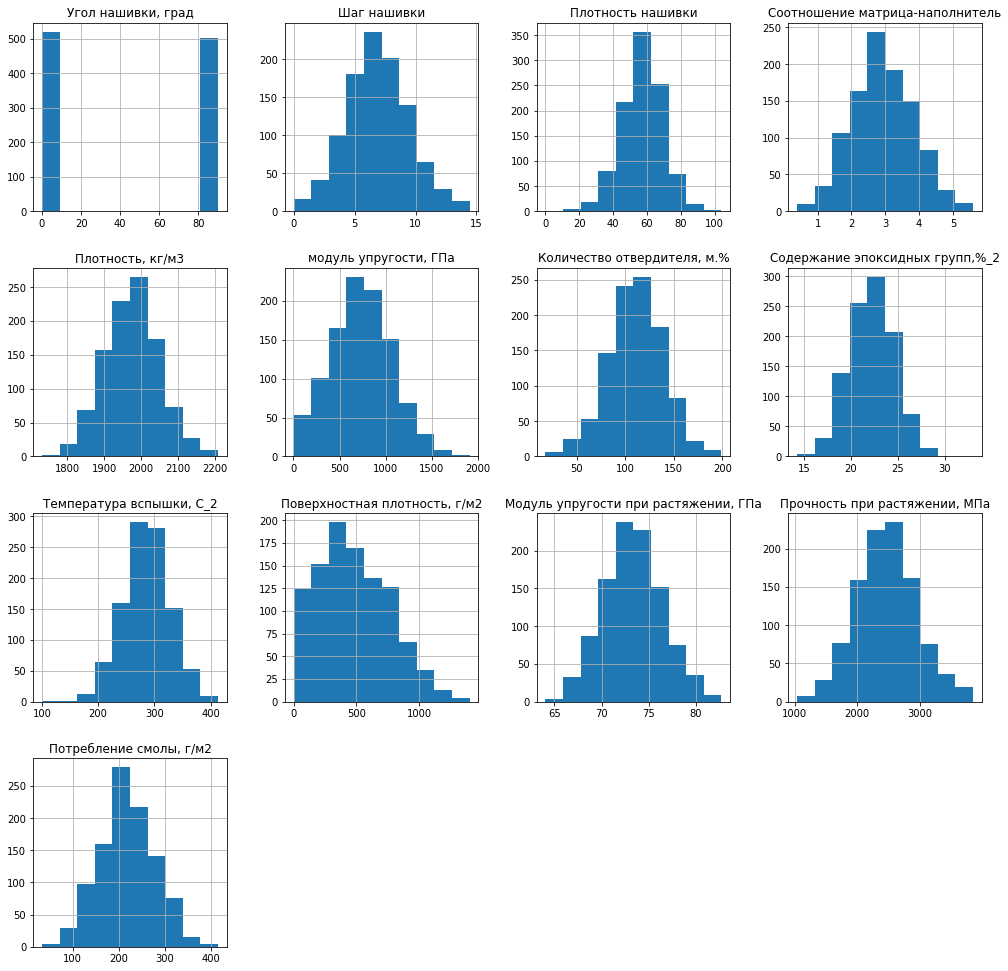

In [ ]:
df.hist(figsize=(17,17))
plt.show()

Попарные графики рассеяния точек

In [ ]:
sns.pairplot(df)

In [ ]:
# дополнительные графики попарного рассевиваения  в привязке к целевой переменной
sns.pairplot(df, hue="Модуль упругости при растяжении, ГПа")

In [ ]:
#дополнительные графики попарного рассевиваения  в привязке к целевой переменной
sns.pairplot(df, hue="Прочность при растяжении, МПа")

#Обучить алгоритм машинного обучения, который будет определять значения:
Модуль упругости при растяжении, ГПа
Прочность при растяжении, МПа

In [ ]:
# положим названия столбцов в отдельный список
names = df.columns
names[0]

'Угол нашивки, град'

Проверим наличие выбросов, при их наличии произведем чистку

Построение Ящика с усами

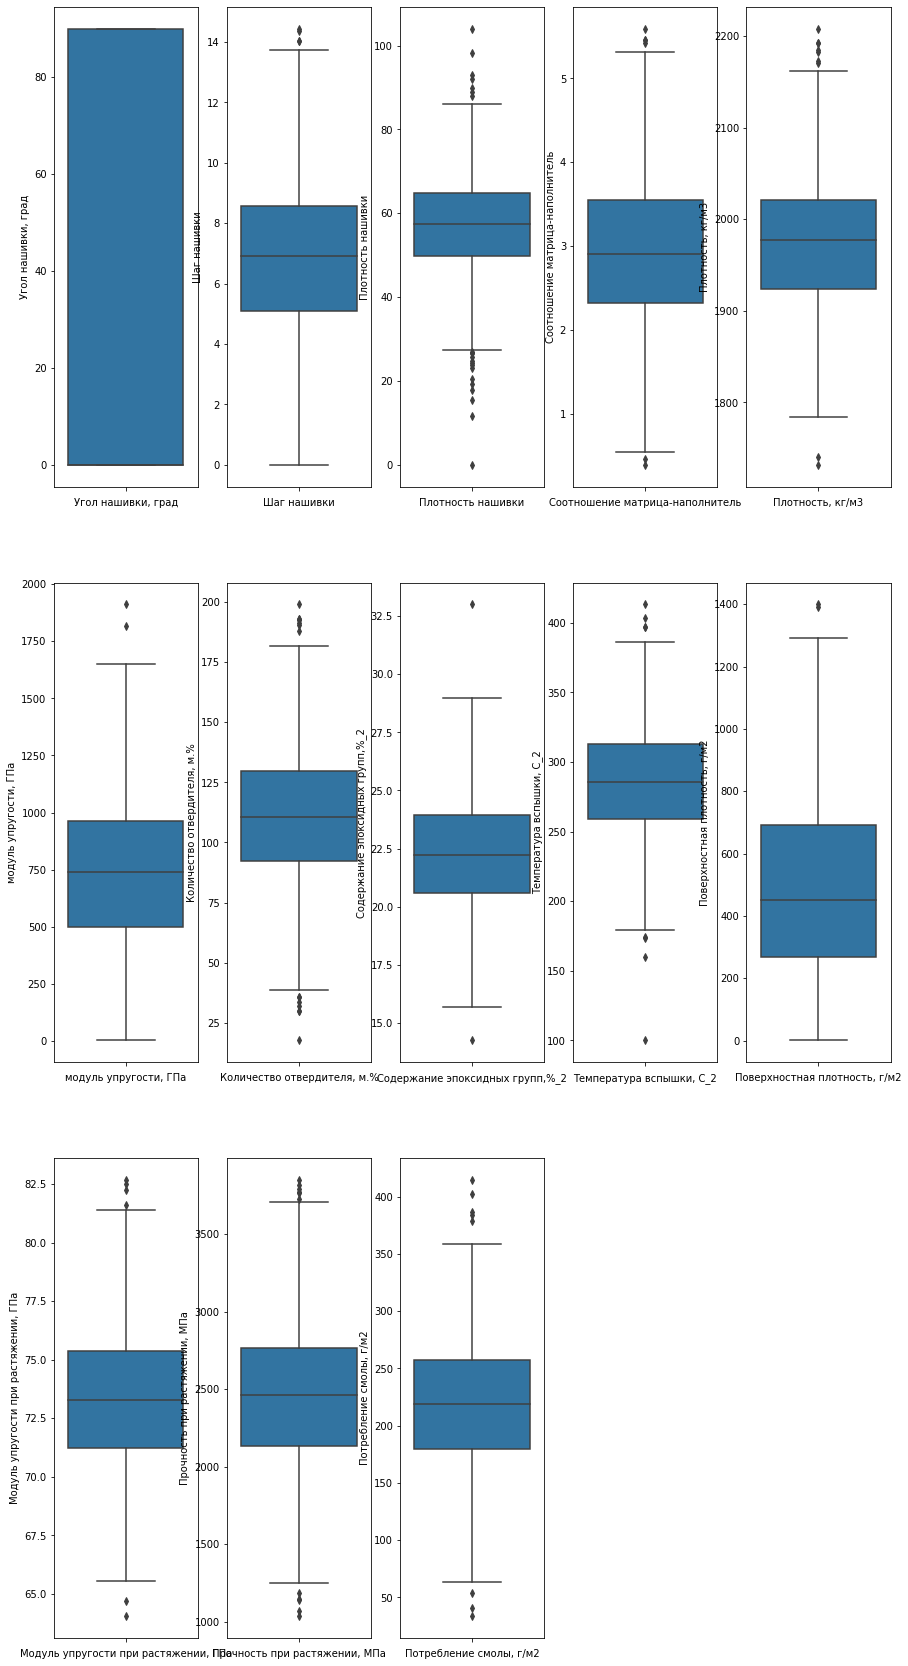

In [ ]:
def box_pl2(df):
  col = 5  # столбцы
  k = 1  # счетчик
  row = 3  # строки

  fig = plt.figure(figsize=(15, 30))

  for i in df.columns:
      plt.subplot(row, col, k)
      plt.xlabel(i)
      sns.boxplot(y = df[i])
      k+=1
    
  plt.show()
box_pl2(df)

Проведем чистку от выбросов методом  межквартильных расстояний

In [ ]:
for i in df.columns:
    q75, q25 = np.percentile(df.loc[:,i], [75,25])
    intr_qr = q75 - q25
    max = q75 + (1.5 * intr_qr)
    min = q25 - (1.5 * intr_qr)
    df.loc[df[i] < min, i] = np.nan
    df.loc[df[i] > max, i] = np.nan
df.dropna(inplace = True)

Построим Ящик с усами после чистки выбросов

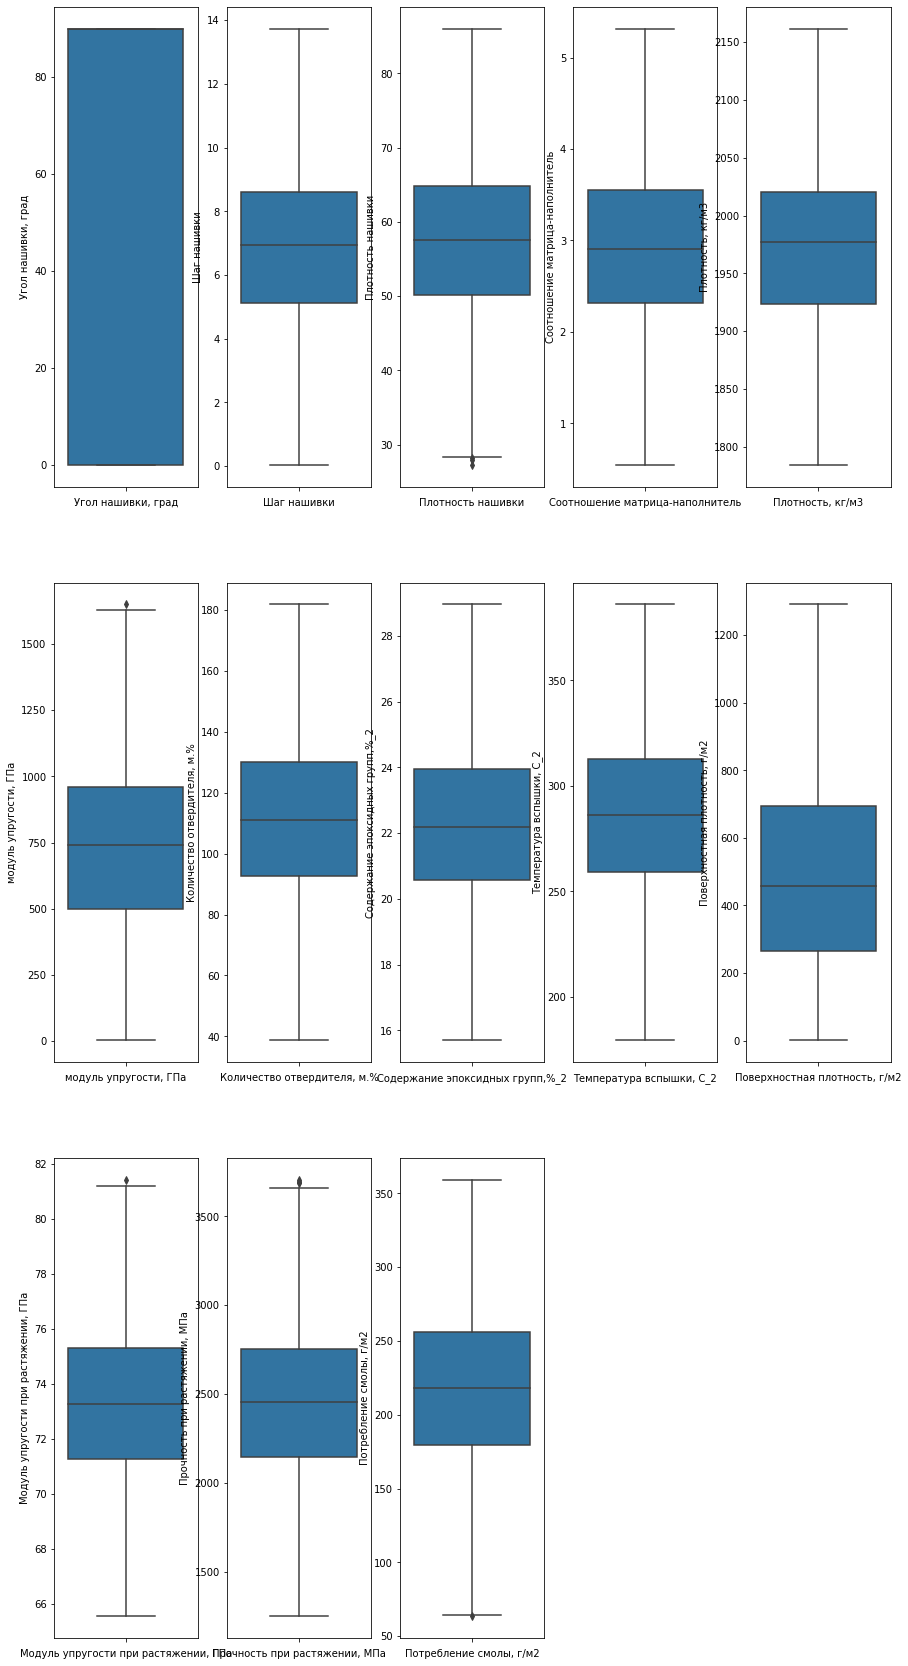

In [ ]:
  plt.show()
box_pl2(df)

Создаем новый датасет без выбросов 

In [ ]:
df_neo = df[(df[i] <max) & (df[i]>min)]
df_neo.reset_index(inplace = True)
df_neo = df_neo.copy()

In [ ]:
df_neo = df_neo.iloc[0:935, 1:14]
df_neo

,"Угол нашивки, град",Шаг нашивки,Плотность нашивки,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2"
0,0.0,4.000000,60.000000,1.857143,2030.000000,738.736842,50.000000,23.750000,284.615385,210.000000,70.000000,3000.000000,220.000000
1,0.0,5.000000,47.000000,1.857143,2030.000000,738.736842,129.000000,21.250000,300.000000,210.000000,70.000000,3000.000000,220.000000
2,0.0,5.000000,57.000000,2.771331,2030.000000,753.000000,111.860000,22.267857,284.615385,210.000000,70.000000,3000.000000,220.000000
3,0.0,5.000000,60.000000,2.767918,2000.000000,748.000000,111.860000,22.267857,284.615385,210.000000,70.000000,3000.000000,220.000000
4,0.0,5.000000,70.000000,2.569620,1910.000000,807.000000,111.860000,22.267857,284.615385,210.000000,70.000000,3000.000000,220.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
930,90.0,8.736592,60.277805,2.758727,2000.506141,934.564388,143.021859,21.379518,273.852679,65.105965,67.633752,3102.539548,229.780372
931,90.0,9.076380,47.019770,2.271346,1952.087902,912.855545,86.992183,20.123249,324.774576,209.198700,73.090961,2387.292495,125.007669
932,90.0,10.565614,53.750790,3.444022,2050.089171,444.732634,145.981978,19.599769,254.215401,350.660830,72.920827,2360.392784,117.730099
933,90.0,4.161154,67.629684,3.280604,1972.372865,416.836524,110.533477,23.957502,248.423047,740.142791,74.734344,2662.906040,236.606764


Построим матрицу корреляции

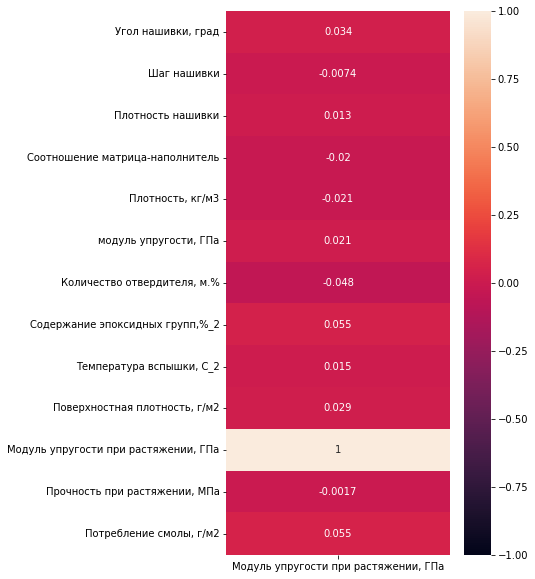

In [ ]:
plt.figure(figsize = (5,10))
sns.heatmap(df_neo.corr()[['Модуль упругости при растяжении, ГПа']], vmin = -1, vmax = 1, annot = True);

In [ ]:
df_neo.corr()[['Модуль упругости при растяжении, ГПа']]

,"Модуль упругости при растяжении, ГПа"
"Угол нашивки, град",0.033866
Шаг нашивки,-0.007429
Плотность нашивки,0.012838
Соотношение матрица-наполнитель,-0.019609
"Плотность, кг/м3",-0.020915
"модуль упругости, ГПа",0.021444
"Количество отвердителя, м.%",-0.048462
"Содержание эпоксидных групп,%_2",0.054637
"Температура вспышки, С_2",0.015229
"Поверхностная плотность, г/м2",0.029312


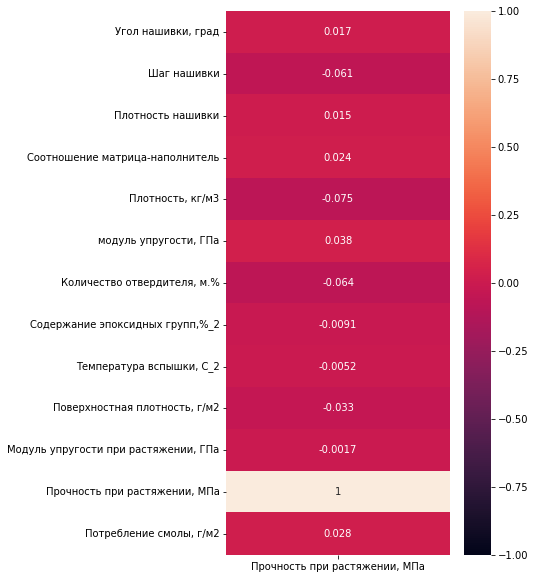

In [ ]:
plt.figure(figsize = (5,10))
sns.heatmap(df_neo.corr()[['Прочность при растяжении, МПа']], vmin = -1, vmax = 1, annot = True);

In [ ]:
df_neo.corr()[['Прочность при растяжении, МПа']]

,"Прочность при растяжении, МПа"
"Угол нашивки, град",0.016807
Шаг нашивки,-0.060946
Плотность нашивки,0.015330
Соотношение матрица-наполнитель,0.023623
"Плотность, кг/м3",-0.075329
"модуль упругости, ГПа",0.037551
"Количество отвердителя, м.%",-0.063902
"Содержание эпоксидных групп,%_2",-0.009098
"Температура вспышки, С_2",-0.005219
"Поверхностная плотность, г/м2",-0.032689


Построим температурную карту

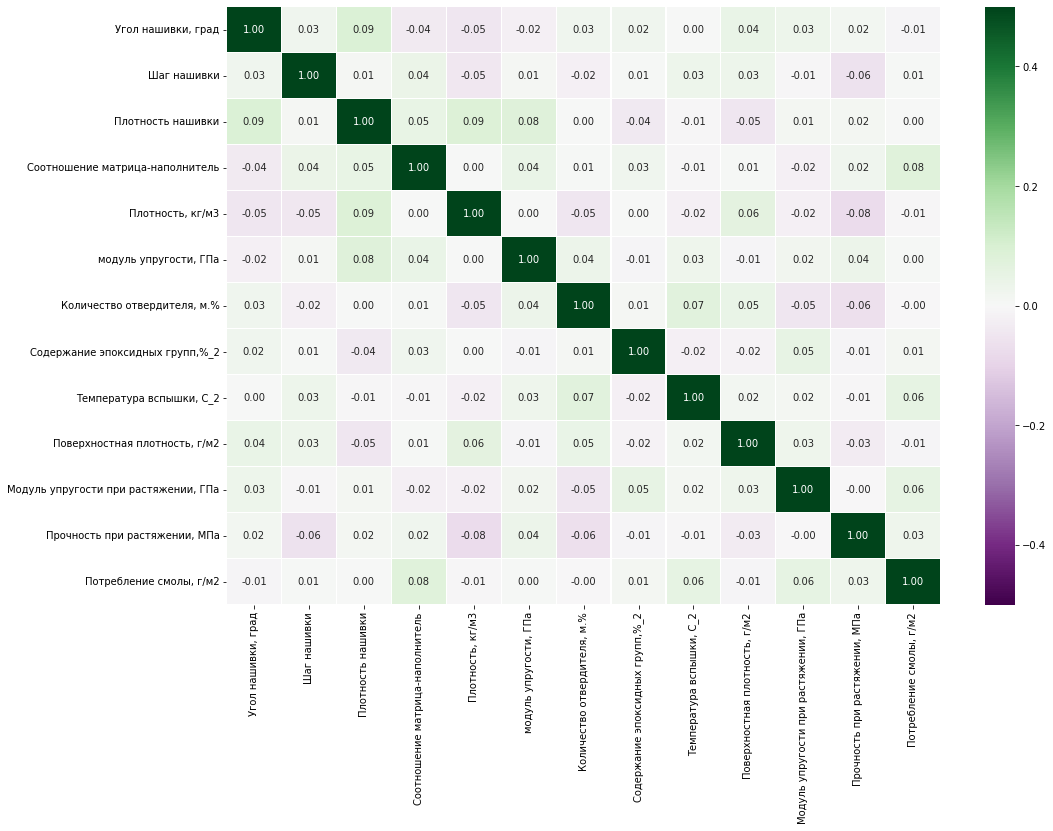

In [ ]:
corr = df_neo.corr()
fig, ax = plt.subplots(figsize=(16, 11))
sns.heatmap(corr, vmin=-0.5, vmax=0.5, annot=True, fmt='.2f',cmap='PRGn', ax=ax, linewidths = 0.1)
plt.show()

Оценим плотность ядра до нормализации

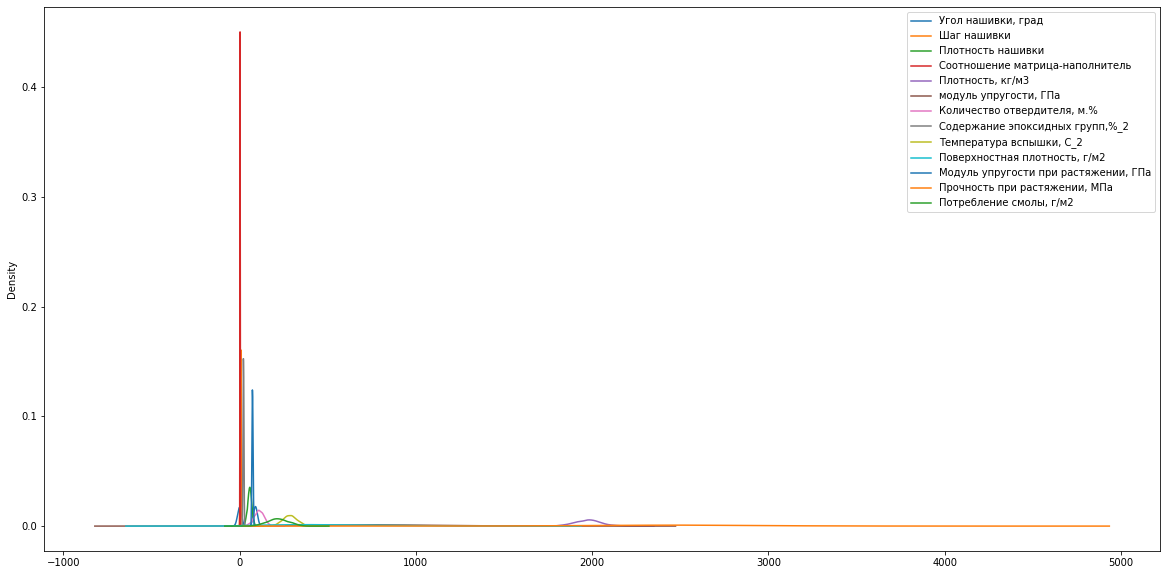

In [ ]:
#оценка параметрического распределения
def plt_kde(df_neo):  
  fig, ax = plt.subplots(figsize=(20, 10))  
  df_neo.plot(kind='kde', ax=ax)
plt_kde(df_neo)

Нормализуем данные

In [ ]:
scaler = preprocessing.MinMaxScaler()
columns = df_neo.columns
df_n = scaler.fit_transform(np.array(df_neo))
df_n = pd.DataFrame(df_n, columns=columns)
df_n.head()

,"Угол нашивки, град",Шаг нашивки,Плотность нашивки,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2"
0,0.0,0.289334,0.557156,0.274768,0.651097,0.447061,0.079153,0.607435,0.509164,0.16223,0.280303,0.71259,0.529221
1,0.0,0.362355,0.335840,0.274768,0.651097,0.447061,0.630983,0.418887,0.583596,0.16223,0.280303,0.71259,0.529221
2,0.0,0.362355,0.506083,0.466552,0.651097,0.455721,0.511257,0.495653,0.509164,0.16223,0.280303,0.71259,0.529221
3,0.0,0.362355,0.557156,0.465836,0.571539,0.452685,0.511257,0.495653,0.509164,0.16223,0.280303,0.71259,0.529221
4,0.0,0.362355,0.727399,0.424236,0.332865,0.488508,0.511257,0.495653,0.509164,0.16223,0.280303,0.71259,0.529221


In [ ]:
scaler.inverse_transform(np.array(df_n)[:1,:])

array([[0.00000000e+00, 4.00000000e+00, 6.00000000e+01, 1.85714286e+00,
        2.03000000e+03, 7.38736842e+02, 5.00000000e+01, 2.37500000e+01,
        2.84615385e+02, 2.10000000e+02, 7.00000000e+01, 3.00000000e+03,
        2.20000000e+02]])

Описательная статистика характеристик после нормализации

In [ ]:
df_n.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
"Угол нашивки, град",935.0,0.51,0.50,0.0,0.00,1.00,1.00,1.0
Шаг нашивки,935.0,0.50,0.18,0.0,0.37,0.50,0.62,1.0
Плотность нашивки,935.0,0.51,0.19,0.0,0.39,0.52,0.64,1.0
Соотношение матрица-наполнитель,935.0,0.50,0.19,0.0,0.37,0.49,0.63,1.0
"Плотность, кг/м3",935.0,0.50,0.19,0.0,0.37,0.51,0.63,1.0
"модуль упругости, ГПа",935.0,0.45,0.20,0.0,0.30,0.45,0.58,1.0
"Количество отвердителя, м.%",935.0,0.50,0.19,0.0,0.38,0.51,0.64,1.0
"Содержание эпоксидных групп,%_2",935.0,0.49,0.18,0.0,0.37,0.49,0.62,1.0
"Температура вспышки, С_2",935.0,0.52,0.19,0.0,0.39,0.52,0.65,1.0
"Поверхностная плотность, г/м2",935.0,0.37,0.22,0.0,0.21,0.35,0.54,1.0


Оценим ящик с усами после нормализации

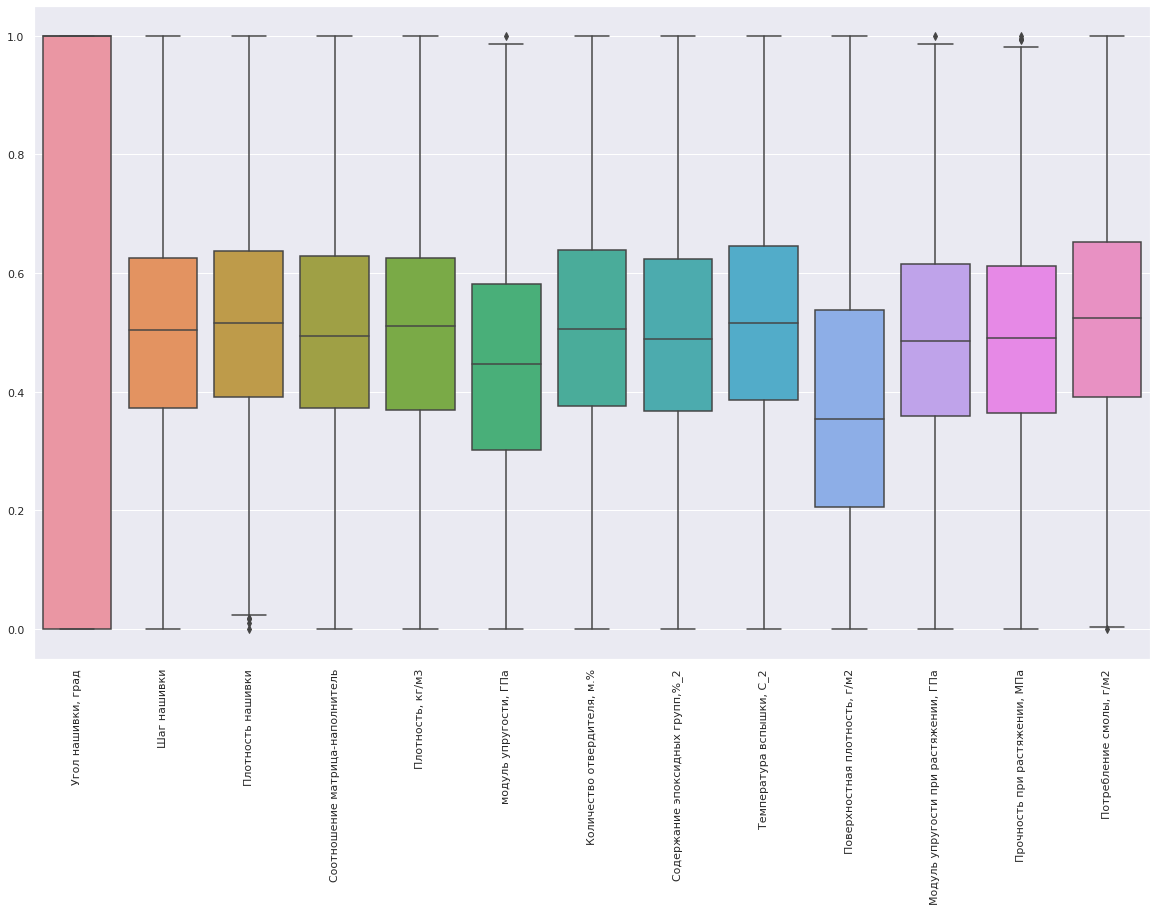

In [ ]:
sns.set(rc={'figure.figsize':(20,12)})
ax = sns.boxplot(data=df_n)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

Плотность ядра после нормолизации

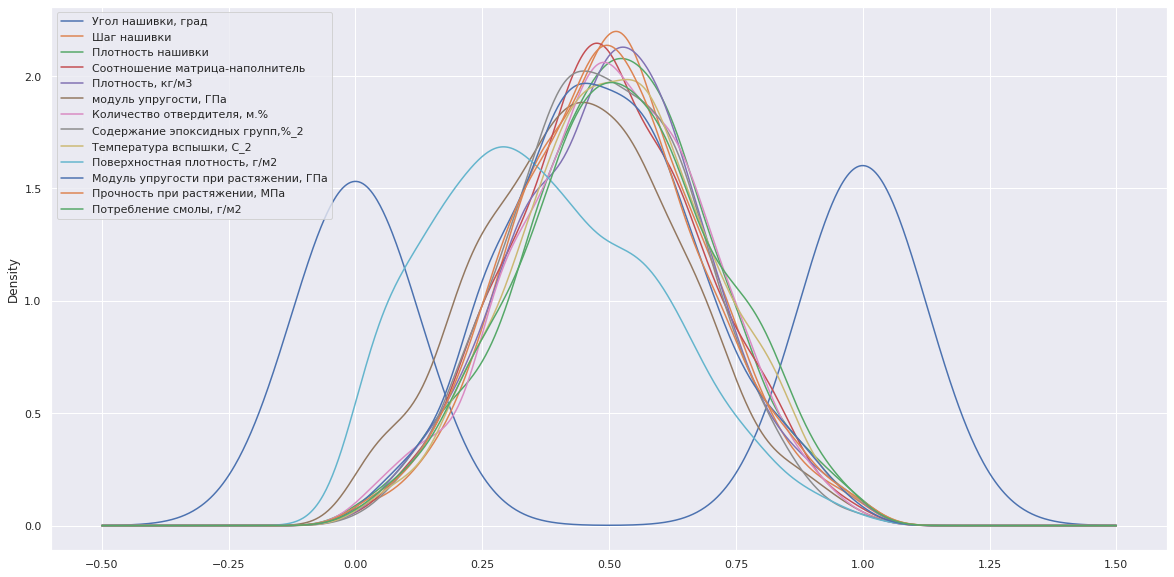

In [ ]:
plt_kde(df_n)#практически все данные имеют нормальное распределение

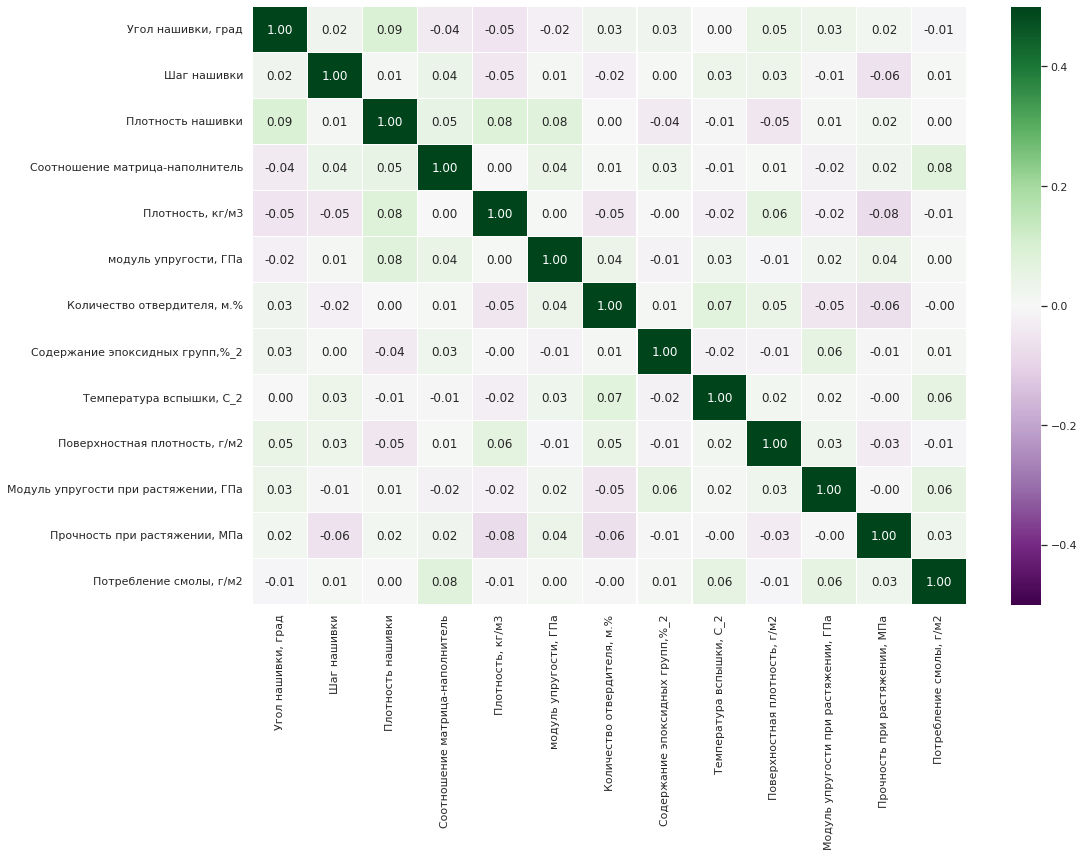

In [ ]:
# Корреялция после нормализации
def get_corr(df_n):
  corr = df.corr()
  fig, ax = plt.subplots(figsize=(16, 11))
  sns.heatmap(corr, vmin=-0.5, vmax=0.5, annot=True, fmt='.2f',cmap='PRGn', ax=ax, linewidths = 0.1)
  plt.show()
get_corr(df_n)

Модели для прогноза модуля упругости при растяжении и прочности при растяжении.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error

In [ ]:
import random

In [ ]:
df_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 935 entries, 0 to 934
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Угол нашивки, град                    935 non-null    float64
 1   Шаг нашивки                           935 non-null    float64
 2   Плотность нашивки                     935 non-null    float64
 3   Соотношение матрица-наполнитель       935 non-null    float64
 4   Плотность, кг/м3                      935 non-null    float64
 5   модуль упругости, ГПа                 935 non-null    float64
 6   Количество отвердителя, м.%           935 non-null    float64
 7   Содержание эпоксидных групп,%_2       935 non-null    float64
 8   Температура вспышки, С_2              935 non-null    float64
 9   Поверхностная плотность, г/м2         935 non-null    float64
 10  Модуль упругости при растяжении, ГПа  935 non-null    float64
 11  Прочность при растя

In [ ]:
#cкачаем датасет в отдельный файл
df_n.to_excel('df_n.xlsx')

#Выберем метод для построения модели

In [ ]:
train_data = TabularDataset(df_n)
subsample_size = 700  #Сделаем 700 примеров (датасетов) для обучения модели 
train_data = train_data.sample(n=subsample_size, random_state=0)
train_data.head()

,"Угол нашивки, град",Шаг нашивки,Плотность нашивки,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2"
689,1.0,0.597733,0.503218,0.438253,0.240593,0.270175,0.387543,0.076893,0.475518,0.636912,0.380037,0.412182,0.769772
236,0.0,0.675736,0.042100,0.278396,0.519208,0.723754,0.632808,0.439393,0.589051,0.127968,0.312930,0.622957,0.594472
738,1.0,0.367461,0.396750,0.501239,0.219070,0.193374,0.267436,0.348809,0.668645,0.505604,0.856659,0.392797,0.523036
766,1.0,0.230811,0.450906,0.509772,0.992653,0.559150,0.814164,0.731661,0.401324,0.243731,0.500638,0.703688,0.487450
266,0.0,0.229111,0.210865,0.532021,0.559514,0.437869,0.559515,0.833244,0.419434,0.129828,0.547037,0.456138,0.277902


Выберем модель для прогнозирования показателя 'Модуль упругости при растяжении, ГПа'

In [ ]:
#Опишем новый датасет - переменную Rating для показателя 'Модуль упругости при растяжении, ГПа'

label = 'Модуль упругости при растяжении, ГПа'
print("Summary of class variable: \n", train_data[label].describe())

Summary of class variable: 
 count    700.000000
mean       0.487794
std        0.192371
min        0.015161
25%        0.357226
50%        0.481502
75%        0.614098
max        1.000000
Name: Модуль упругости при растяжении, ГПа, dtype: float64


In [ ]:
#Обучим модель для показателя 'Модуль упругости при растяжении, ГПа'
save_path = 'agModels-predictClass'  
predictor = TabularPredictor(label=label, path=save_path).fit(train_data)

Beginning AutoGluon training ...
AutoGluon will save models to "agModels-predictClass/"
AutoGluon Version:  0.6.1
Python Version:     3.8.16
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Aug 26 08:44:51 UTC 2022
Train Data Rows:    700
Train Data Columns: 12
Label Column: Модуль упругости при растяжении, ГПа
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (1.0, 0.015160882489319683, 0.48779, 0.19237)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    12486.74 MB
	Train Data (Original)  Memory Usage: 0.07 MB (0.0% of avai

In [ ]:
#Сделаем обработку датасета для применения модели для показателя 'Модуль упругости при растяжении, ГПа'
test_data = TabularDataset(df_n)
y_test = test_data[label]  
test_data_nolab = test_data.drop(columns=[label])  
test_data_nolab.head()

,"Угол нашивки, град",Шаг нашивки,Плотность нашивки,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Прочность при растяжении, МПа","Потребление смолы, г/м2"
0,0.0,0.289334,0.557156,0.274768,0.651097,0.447061,0.079153,0.607435,0.509164,0.16223,0.71259,0.529221
1,0.0,0.362355,0.335840,0.274768,0.651097,0.447061,0.630983,0.418887,0.583596,0.16223,0.71259,0.529221
2,0.0,0.362355,0.506083,0.466552,0.651097,0.455721,0.511257,0.495653,0.509164,0.16223,0.71259,0.529221
3,0.0,0.362355,0.557156,0.465836,0.571539,0.452685,0.511257,0.495653,0.509164,0.16223,0.71259,0.529221
4,0.0,0.362355,0.727399,0.424236,0.332865,0.488508,0.511257,0.495653,0.509164,0.16223,0.71259,0.529221


In [ ]:
#Посмотрим на метрики модели для показателя 'Модуль упругости при растяжении, ГПа'
predictor = TabularPredictor.load(save_path)  

y_pred = predictor.predict(test_data_nolab)
print("Predictions:  \n", y_pred)
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)

Evaluation: root_mean_squared_error on test data: -0.18440657680338338
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -0.18440657680338338,
    "mean_squared_error": -0.034005785568342134,
    "mean_absolute_error": -0.1487492254333255,
    "r2": 0.07227519004665917,
    "pearsonr": 0.5143205087756306,
    "median_absolute_error": -0.12530628610228245
}


Predictions:  
 0      0.494964
1      0.484233
2      0.476393
3      0.475451
4      0.473141
         ...   
930    0.458142
931    0.492264
932    0.467150
933    0.482497
934    0.492006
Name: Модуль упругости при растяжении, ГПа, Length: 935, dtype: float32


In [ ]:
#Выведем таблицу, которая будет сравнивать между собой все модели для показателя 'Модуль упругости при растяжении, ГПа'
results = predictor.leaderboard(test_data, silent=True)
results

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,ExtraTreesMSE,-0.134088,-0.192911,0.111652,0.044489,0.717061,0.111652,0.044489,0.717061,1,True,7
1,RandomForestMSE,-0.136455,-0.193548,0.100802,0.064320,1.272497,0.100802,0.064320,1.272497,1,True,5
2,KNeighborsDist,-0.137210,-0.218559,0.019609,0.006704,0.017073,0.019609,0.006704,0.017073,1,True,2
3,WeightedEnsemble_L2,-0.184407,-0.188037,0.136346,0.087198,2.403532,0.002852,0.000499,0.358163,2,True,12
4,LightGBMLarge,-0.185524,-0.188642,0.003647,0.003065,0.919936,0.003647,0.003065,0.919936,1,True,11
5,LightGBM,-0.187256,-0.189282,0.003055,0.003468,0.456363,0.003055,0.003468,0.456363,1,True,4
6,XGBoost,-0.188257,-0.191509,0.015501,0.005847,0.831184,0.015501,0.005847,0.831184,1,True,9
7,CatBoost,-0.191245,-0.189175,0.004543,0.001922,1.305503,0.004543,0.001922,1.305503,1,True,6
8,LightGBMXT,-0.191255,-0.189427,0.003979,0.003097,0.836640,0.003979,0.003097,0.836640,1,True,3
9,NeuralNetTorch,-0.191284,-0.189860,0.013395,0.005898,0.865709,0.013395,0.005898,0.865709,1,True,10


In [ ]:
#самой лучшей моделью  для показателя 'Модуль упругости при растяжении, ГПа' оказались KNeighborsUnif KNeighborsDist , хуже всех отработали WeightedEnsemble_L2	LightGBMLarge	
results.sort_values('fit_order')

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
10,KNeighborsUnif,-0.191583,-0.218835,0.018240,0.007125,2.827599,0.018240,0.007125,2.827599,1,True,1
2,KNeighborsDist,-0.137210,-0.218559,0.019609,0.006704,0.017073,0.019609,0.006704,0.017073,1,True,2
8,LightGBMXT,-0.191255,-0.189427,0.003979,0.003097,0.836640,0.003979,0.003097,0.836640,1,True,3
5,LightGBM,-0.187256,-0.189282,0.003055,0.003468,0.456363,0.003055,0.003468,0.456363,1,True,4
1,RandomForestMSE,-0.136455,-0.193548,0.100802,0.064320,1.272497,0.100802,0.064320,1.272497,1,True,5
7,CatBoost,-0.191245,-0.189175,0.004543,0.001922,1.305503,0.004543,0.001922,1.305503,1,True,6
0,ExtraTreesMSE,-0.134088,-0.192911,0.111652,0.044489,0.717061,0.111652,0.044489,0.717061,1,True,7
11,NeuralNetFastAI,-0.191729,-0.188114,0.032691,0.022379,0.772871,0.032691,0.022379,0.772871,1,True,8
6,XGBoost,-0.188257,-0.191509,0.015501,0.005847,0.831184,0.015501,0.005847,0.831184,1,True,9
9,NeuralNetTorch,-0.191284,-0.189860,0.013395,0.005898,0.865709,0.013395,0.005898,0.865709,1,True,10


Выберем модель для прогнозирования показателя 'Прочность при растяжении, МПа'

In [ ]:
#Опишем новый датасет - переменную Rating для показателя 'Прочность при растяжении, МПа'

label1 = 'Прочность при растяжении, МПа'
print("Summary of class variable: \n", train_data[label1].describe())

Summary of class variable: 
 count    700.000000
mean       0.497833
std        0.189667
min        0.000000
25%        0.367182
50%        0.491824
75%        0.611305
max        1.000000
Name: Прочность при растяжении, МПа, dtype: float64


In [ ]:
#Обучим модель для показателя 'Прочность при растяжении, МПа'
save_path = 'agModels-predictClass'  
predictor = TabularPredictor(label=label1, path=save_path).fit(train_data)

Beginning AutoGluon training ...
AutoGluon will save models to "agModels-predictClass/"
AutoGluon Version:  0.6.1
Python Version:     3.8.16
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Aug 26 08:44:51 UTC 2022
Train Data Rows:    700
Train Data Columns: 12
Label Column: Прочность при растяжении, МПа
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (1.0, 0.0, 0.49783, 0.18967)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    12393.89 MB
	Train Data (Original)  Memory Usage: 0.07 MB (0.0% of available memory)
	Inferring

In [ ]:
#Сделаем обработку датасета для применения модели для показателя 'Прочность при растяжении, МПа'
test_data = TabularDataset(df_n)
y_test = test_data[label1]  
test_data_nolab = test_data.drop(columns=[label1])  
test_data_nolab.head()

,"Угол нашивки, град",Шаг нашивки,Плотность нашивки,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Потребление смолы, г/м2"
0,0.0,0.289334,0.557156,0.274768,0.651097,0.447061,0.079153,0.607435,0.509164,0.16223,0.280303,0.529221
1,0.0,0.362355,0.335840,0.274768,0.651097,0.447061,0.630983,0.418887,0.583596,0.16223,0.280303,0.529221
2,0.0,0.362355,0.506083,0.466552,0.651097,0.455721,0.511257,0.495653,0.509164,0.16223,0.280303,0.529221
3,0.0,0.362355,0.557156,0.465836,0.571539,0.452685,0.511257,0.495653,0.509164,0.16223,0.280303,0.529221
4,0.0,0.362355,0.727399,0.424236,0.332865,0.488508,0.511257,0.495653,0.509164,0.16223,0.280303,0.529221


In [ ]:
#Посмотрим на метрики модели для показателя 'Прочность при растяжении, МПа'
predictor = TabularPredictor.load(save_path)  

y_pred = predictor.predict(test_data_nolab)
print("Predictions:  \n", y_pred)
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)

Evaluation: root_mean_squared_error on test data: -0.16763731003058424
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -0.16763731003058424,
    "mean_squared_error": -0.028102267714290217,
    "mean_absolute_error": -0.1308311550254636,
    "r2": 0.21198250649375827,
    "pearsonr": 0.5407601270180226,
    "median_absolute_error": -0.10756113166673553
}


Predictions:  
 0      0.528349
1      0.538266
2      0.569535
3      0.563854
4      0.544983
         ...   
930    0.564924
931    0.525264
932    0.456224
933    0.511074
934    0.471135
Name: Прочность при растяжении, МПа, Length: 935, dtype: float32


In [ ]:
#Выведем таблицу, которая будет сравнивать между собой все модели для показателя 'Прочность при растяжении, МПа'
results1 = predictor.leaderboard(test_data, silent=True)
results1

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,ExtraTreesMSE,-0.132016,-0.189995,0.097907,0.073004,0.719902,0.097907,0.073004,0.719902,1,True,7
1,RandomForestMSE,-0.132731,-0.191791,0.124538,0.068834,1.344347,0.124538,0.068834,1.344347,1,True,5
2,KNeighborsDist,-0.133194,-0.215786,0.019160,0.007360,0.011671,0.019160,0.007360,0.011671,1,True,2
3,CatBoost,-0.144109,-0.189779,0.007115,0.001916,2.232526,0.007115,0.001916,2.232526,1,True,6
4,LightGBMXT,-0.162601,-0.190270,0.012246,0.004084,0.426740,0.012246,0.004084,0.426740,1,True,3
5,WeightedEnsemble_L2,-0.167637,-0.186205,0.023132,0.007943,3.837466,0.002692,0.000483,0.348943,2,True,12
6,LightGBM,-0.176315,-0.189455,0.004364,0.004219,0.493147,0.004364,0.004219,0.493147,1,True,4
7,LightGBMLarge,-0.178649,-0.190255,0.003716,0.004298,0.941188,0.003716,0.004298,0.941188,1,True,11
8,NeuralNetTorch,-0.179878,-0.186683,0.013325,0.005544,1.255996,0.013325,0.005544,1.255996,1,True,10
9,KNeighborsUnif,-0.185344,-0.215545,0.019436,0.010075,0.025239,0.019436,0.010075,0.025239,1,True,1


In [ ]:
#самой лучшей моделью  для показателя 'Прочность при растяжении, МПа' оказались KNeighborsUnif KNeighborsDist , хуже всех отработали WeightedEnsemble_L2	LightGBMLarge	
results1.sort_values('fit_order')

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
9,KNeighborsUnif,-0.185344,-0.215545,0.019436,0.010075,0.025239,0.019436,0.010075,0.025239,1,True,1
2,KNeighborsDist,-0.133194,-0.215786,0.019160,0.007360,0.011671,0.019160,0.007360,0.011671,1,True,2
4,LightGBMXT,-0.162601,-0.190270,0.012246,0.004084,0.426740,0.012246,0.004084,0.426740,1,True,3
6,LightGBM,-0.176315,-0.189455,0.004364,0.004219,0.493147,0.004364,0.004219,0.493147,1,True,4
1,RandomForestMSE,-0.132731,-0.191791,0.124538,0.068834,1.344347,0.124538,0.068834,1.344347,1,True,5
3,CatBoost,-0.144109,-0.189779,0.007115,0.001916,2.232526,0.007115,0.001916,2.232526,1,True,6
0,ExtraTreesMSE,-0.132016,-0.189995,0.097907,0.073004,0.719902,0.097907,0.073004,0.719902,1,True,7
11,NeuralNetFastAI,-0.187674,-0.190785,0.031074,0.012887,0.656400,0.031074,0.012887,0.656400,1,True,8
10,XGBoost,-0.185680,-0.191511,0.024560,0.005684,0.780765,0.024560,0.005684,0.780765,1,True,9
8,NeuralNetTorch,-0.179878,-0.186683,0.013325,0.005544,1.255996,0.013325,0.005544,1.255996,1,True,10


# Прогнозирование ответов по лучшей модели
таким образом, для обоих показателей лучшие результаты показал метод к-ближайших соседей

In [ ]:
#Визуализация предсказанных значений целевых переменных
def predicted_plot(y_test, y_pred, model_name):
  plt.figure(figsize=(15,9))
  plt.title(f'Тестовые и прогнозные значения, Модуль 1: {model_name}')
  plt.plot(y_test.to_numpy()[:,0], label='Тест')
  plt.plot(y_pred[:,0], label='Прогноз')
  plt.legend(loc='best')
  plt.ylabel('н')
  plt.xlabel('Порядок')

  plt.figure(figsize=(15,9))
  plt.title(f'Тестовые и прогнозные значения, Модуль 1: {model_name}')
  plt.plot(y_test.to_numpy()[:,1], label='Тест')
  plt.plot(y_pred[:,1], label='Прогноз')
  plt.legend(loc='best')
  plt.ylabel('н')
  plt.xlabel('Порядок')
# Для одной целевой переменной
def predicted_ns(y_test, y_pred):
  plt.figure(figsize=(15,9))
  plt.title(f'Тест и прогноз, Соотношение М-Н: ')
  plt.plot(y_test.to_numpy(), label='Тест')
  plt.plot(y_pred, label='Прогноз')
  plt.legend(loc='best')
  plt.ylabel('н')
  plt.xlabel('Порядок')

Входы и выходы для моделей

In [ ]:
y_label = ['Модуль упругости при растяжении, ГПа', 'Прочность при растяжении, МПа']
y = df_n[y_label] 
X = df_n.drop(y_label, axis = 1)
y.shape,X.shape

((935, 2), (935, 11))

Разделяем датасет на обучающую и тестовую выборки

In [ ]:
from sklearn.model_selection import train_test_split
model_list = [] # список в котором будем хранить лучше модели
X_train, X_test, y_train,y_test = train_test_split(X, y , test_size=0.3, random_state=42)

Итоговый датасет ошибок

In [ ]:
loss_df = pd.DataFrame(columns=['target','model','MSE','R2'])

In [ ]:
import warnings
warnings.filterwarnings("default", category=FutureWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
import tensorflow as tf
from tensorflow import keras

#Линейная регрессия 

In [ ]:
X_train.dropna().shape, X_train.shape

((654, 11), (654, 11))

In [ ]:

del loss_df
loss_df =pd.DataFrame([])
model = LinearRegression()
model.fit(X_train,  y_train)
y_pred = model.predict(X_test)


model_name = 'Linear Regression'
def add_loss(loss_df, model_name):
  MSE = mean_squared_error(y_test, y_pred)
  R2 = r2_score(y_test, y_pred)
  df = pd.DataFrame({'model':model_name,\
                                'target':['Модуль упругости и Прочность'],\
                                'MSE':MSE,\
                                'R2':R2})
  # print(df.head())
  loss_df = pd.concat([loss_df, df],ignore_index=True)
  return loss_df
loss_df = add_loss(loss_df, model_name)


In [ ]:
loss_df.head()

,model,target,MSE,R2
0,Linear Regression,Модуль упругости и Прочность,0.035569,-0.006587


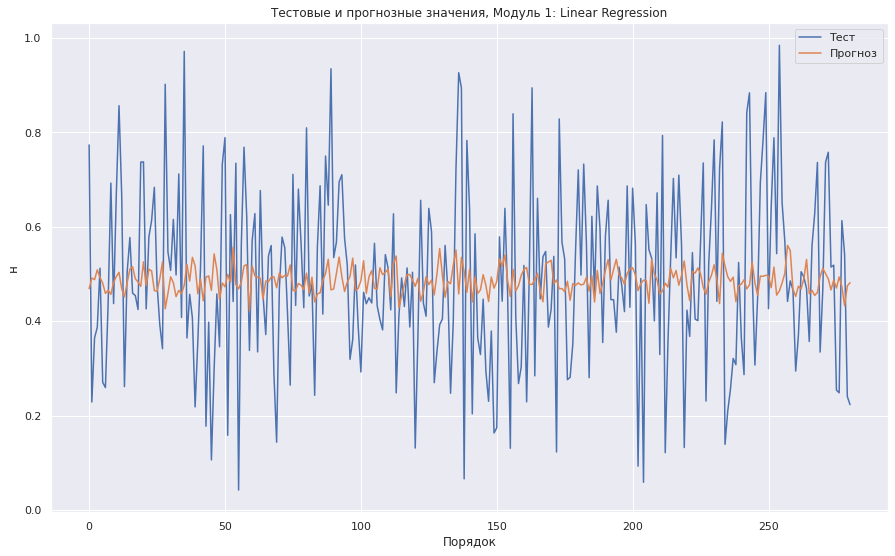

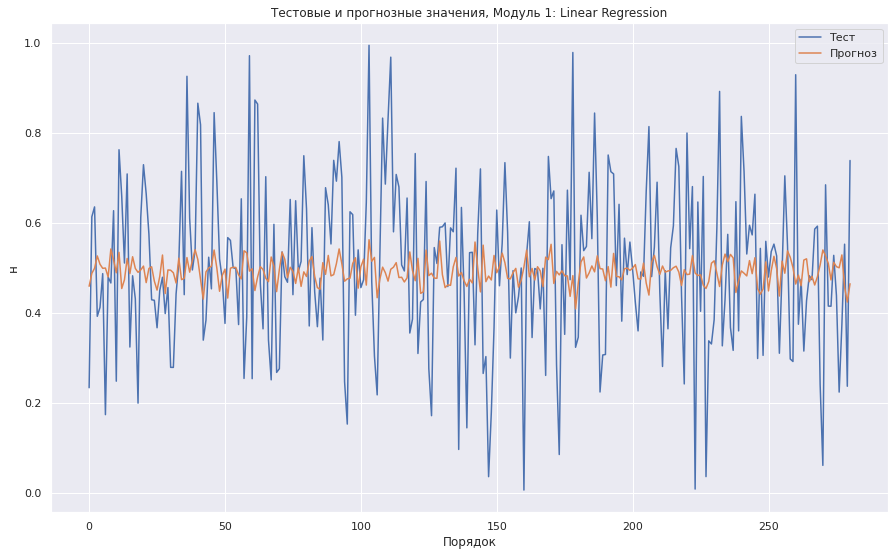

In [ ]:
predicted_plot(y_test, y_pred, model_name)#визуализация данных

#Регрессия k-ближайших соседей

In [ ]:

model = KNeighborsRegressor()
grid = {'n_neighbors' : range(1, 101, 1), 
          'weights' : ['uniform', 'distance'],
          'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']
          }

gsc = GridSearchCV(model, grid, n_jobs=-1, cv=10,verbose = 1)
gsc.fit(X_train,  y_train)
model = gsc.best_estimator_
model.fit(X_train,  y_train)
y_pred = model.predict(X_test)
MSE = mean_squared_error(y_test,y_pred)
R2 = r2_score(y_test,y_pred)
model_name = 'KNeighborsRegressor'
model_list.append(model)
loss_df = add_loss(loss_df,model_name)
model

Fitting 10 folds for each of 800 candidates, totalling 8000 fits


KNeighborsRegressor(n_neighbors=100)

Визуализируем полученный результат

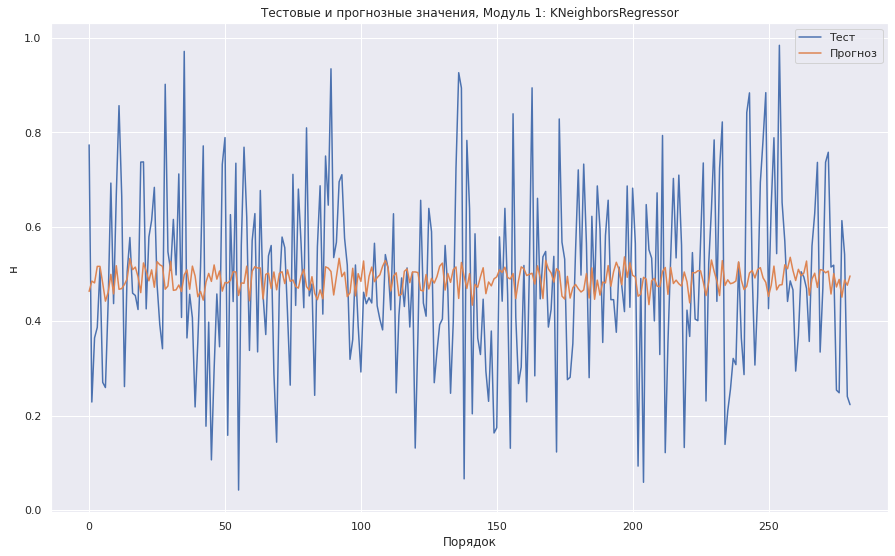

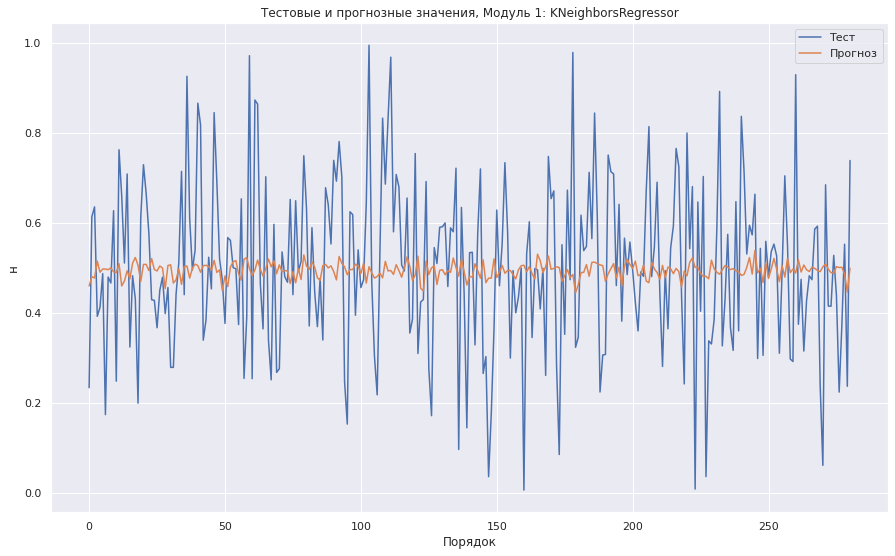

In [ ]:
predicted_plot(y_test, y_pred,model_name)

In [ ]:
loss_df.head()#посмотрим ошибки

,model,target,MSE,R2
0,Linear Regression,Модуль упругости и Прочность,0.035569,-0.006587
1,KNeighborsRegressor,Модуль упругости и Прочность,0.035161,0.004965


#Рекомендательная нейросеть для соотношения матрица-наполнитель

In [ ]:
df_n.columns

Index(['Угол нашивки, град', 'Шаг нашивки', 'Плотность нашивки',
       'Соотношение матрица-наполнитель', 'Плотность, кг/м3',
       'модуль упругости, ГПа', 'Количество отвердителя, м.%',
       'Содержание эпоксидных групп,%_2', 'Температура вспышки, С_2',
       'Поверхностная плотность, г/м2', 'Модуль упругости при растяжении, ГПа',
       'Прочность при растяжении, МПа', 'Потребление смолы, г/м2'],
      dtype='object')

In [ ]:
y = df_n['Соотношение матрица-наполнитель']
X = df_n.drop(['Соотношение матрица-наполнитель'], axis = 1)

X_train, X_test, y_train,y_test = train_test_split(X, y , test_size=0.3, random_state=42)
y.shape,X.shape

((935,), (935, 12))

In [ ]:
from keras.engine.sequential import Sequential
from keras import layers
from keras import models
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 1])
    plt.xlabel('Эпоха')

    plt.ylabel('MAE [MPG]')
    plt.legend()
    plt.grid(True)
model = Sequential()
model.add(layers.Dense(64, input_dim=X.shape[1], activation='relu'))
model.add(layers.Dropout(0.12))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.12))
#model.add(layers.Dense(19, activation='relu')) 
#model.add(layers.Dropout(0.12))
#model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dropout(0.12))
model.add(layers.Dense(12, activation='softmax'))
model.add(layers.Dense(1))

При добавлении слоев и нейронов а так же эпох очучения модель показывает худший результат.

In [ ]:
model.summary()
dfmodel = model.compile(optimizer='adam', loss='mae', metrics=['mae'])
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    verbose=1, epochs=40)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                832       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 12)                780       
                                                                 
 dense_3 (Dense)             (None, 1)                 13        
                                                                 
Total params: 5,785
Trainable params: 5,785
Non-trainabl

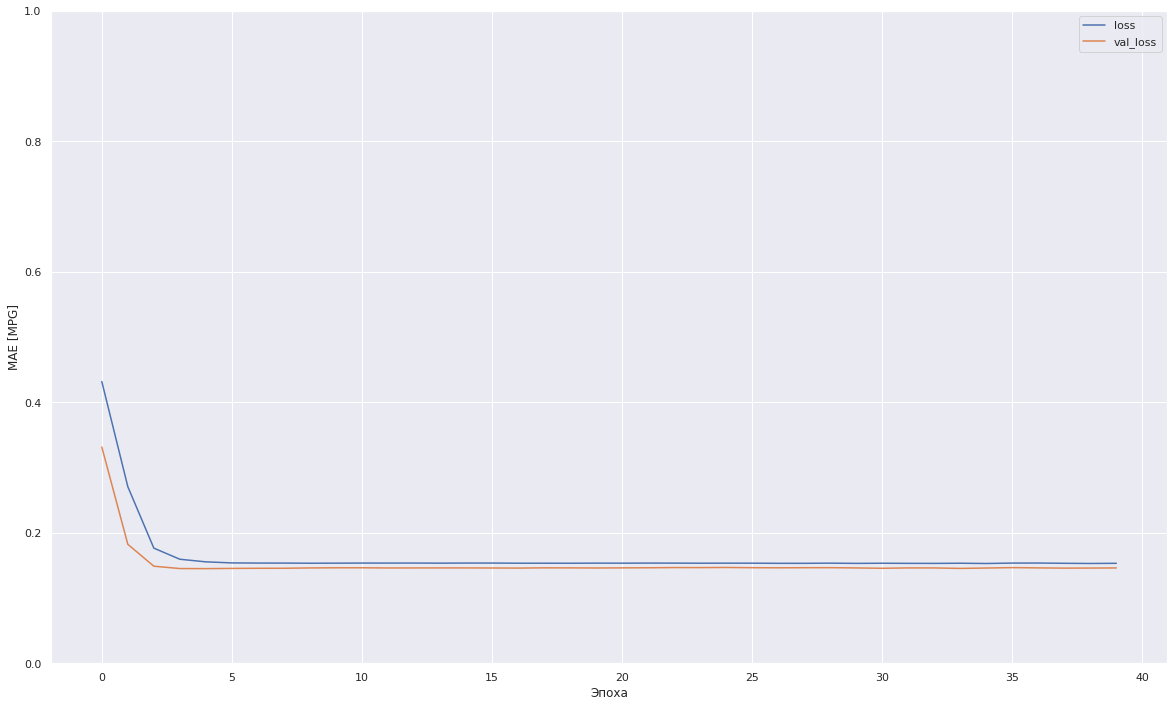

In [ ]:
plot_loss(history)

9/9 [==============================] - 0s 3ms/step


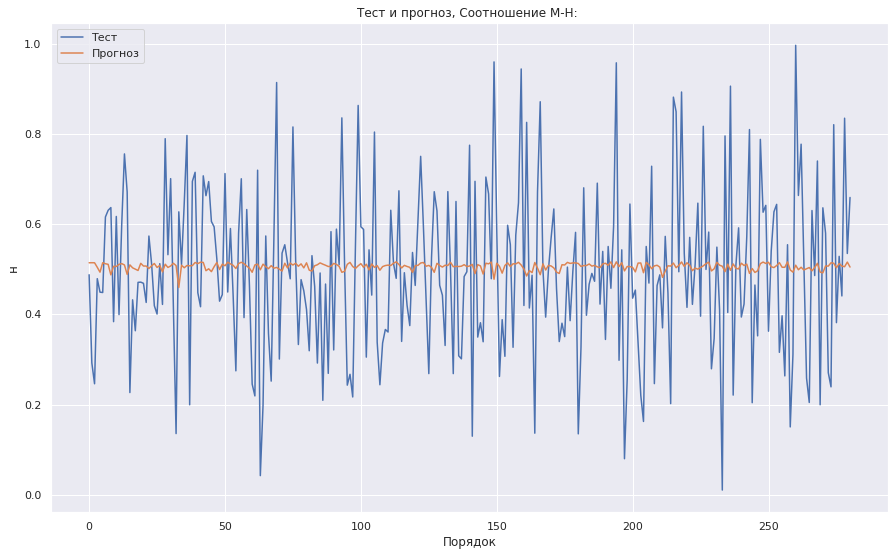

In [ ]:
predicted_ns(y_test, model.predict(X_test))#визуализация

Оценка MSE

In [ ]:
model.evaluate(X_test, y_test, verbose=1)

9/9 [==============================] - 0s 2ms/step - loss: 0.1469 - mae: 0.1469


[0.1469409167766571, 0.1469409167766571]

Датасет с ошибками модели

In [ ]:
MSE = mean_squared_error(y_test, model.predict(X_test.values))
R2 = r2_score(y_test, model.predict(X_test.values))

print(f'MSE NN = {MSE}')
print(f'R2_score NN = {R2}')

9/9 [==============================] - 0s 2ms/step
MSE NN = 0.034277017025998745
R2_score NN = -0.009924938252649396


# Cоздадим приложение 
Воспользуемся фреймворками flask и ngrok
применив их в среде для разработки Google Colab





In [ ]:
!pip install flask --quiet
!pip install flask-ngrok --quiet
print("Completed!")

Completed!


In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.tgz

--2022-12-19 19:08:57--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.tgz
Resolving bin.equinox.io (bin.equinox.io)... 18.205.222.128, 54.161.241.46, 54.237.133.81, ...
Connecting to bin.equinox.io (bin.equinox.io)|18.205.222.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13770165 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.tgz’

ngrok-stable-linux- 100%[===================>]  13.13M  17.4MB/s    in 0.8s    

2022-12-19 19:08:58 (17.4 MB/s) - ‘ngrok-stable-linux-amd64.tgz’ saved [13770165/13770165]



In [ ]:
!tar -xvf /content/ngrok-stable-linux-amd64.tgz

ngrok


In [ ]:
!./ngrok authtoken 2J6I5KKnMkDW9IsuKaxvksnhoGM_6qV3Pgc3qZ23wcjubqxej

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
pip install flask-ngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
for model in model_list:
  print(model)

KNeighborsRegressor(n_neighbors=100)


In [ ]:
model = model_list
from joblib import dump, load

dump(model, 'filename.joblib')

['filename.joblib']

In [ ]:
model = load('filename.joblib') 

In [ ]:
 from flask import Flask, request, render_template
 from keras.models import load_model
 import pandas as pd
 from flask import Flask
 from flask_ngrok import run_with_ngrok
  
 app = Flask(__name__) 
 run_with_ngrok(app)

 @app.route('/', methods=['GET', 'POST'])
 def compute():
     result = ''
     error = dict()
     if request.method == 'POST':
         data = request.form
         try:
             data1 = {k:[float(v)] for k,v in data.items()}
         except ValueError:
             for k,v in data.items():
                 try:
                     float(v)
                 except ValueError:
                     error['name'] = k
                     error['value'] = v
                     break
         if not error:
             input = pd.DataFrame(data=data1)
             result = model.predict(input)[0][0]
     return render_template('index.html', result=result, error=error)

 if __name__ == '__main__':
     #model = load_model('./model/')
     app.run()


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://e8a8-35-203-140-203.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


ERROR:__main__:Exception on / [GET]
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.8/dist-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.8/dist-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/usr/local/lib/python3.8/dist-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/usr/local/lib/python3.8/dist-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/usr/local/lib/python3.8/dist-packages/flask/app.py", line 1936, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-199-72bab4889c36>", line 31, in compute
    return render_template('index.html', result=result, error=error)
  File 